In [ ]:
!pip install torchviz
!pip install graphviz
!pip install torchview

!pip install torchinfo

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
ERROR: Operation cancelled by user
ERROR: Operation cancelled by user


In [ ]:

import os
import math
import random

import cv2
import numpy as np
import time

import matplotlib.pyplot as plt

import torch
from torch.nn import init
from torch import nn, optim
from torchinfo import summary
from torch.nn import functional as F
from torchvision.io import read_image
from torch.nn.utils import spectral_norm
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import functional as TF
from torchviz import make_dot
from torchview import draw_graph


import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Device: {device}')

Device: cuda


In [ ]:
class SRDataset(Dataset):
    def __init__(self, path, mode='train'):
        if mode == 'train':
            self.hr_path = os.path.join(path, 'hr_crop')
            self.lr_path = os.path.join(path, 'lr_crop')
        elif mode == 'test':
            self.hr_path = os.path.join(path, 'hr')
            self.lr_path = os.path.join(path, 'lr')

        # Filter to include only .png files
        self.hr_images = [file for file in sorted(os.listdir(self.hr_path)) if file.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]
        self.lr_images = [file for file in sorted(os.listdir(self.lr_path)) if file.endswith(('.png', '.jpg', '.jpeg', '.bmp'))]

        self.mode = mode

    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, index):
        hr_image_filename = self.hr_images[index]
        lr_image_filename = 'lr_' + hr_image_filename
        hr_image_path = os.path.join(self.hr_path, hr_image_filename)
        lr_image_path = os.path.join(self.lr_path, lr_image_filename)
        hr_image = read_image(hr_image_path) / 255.
        lr_image = read_image(lr_image_path) / 255.

        if self.mode == 'train':
            # Apply random flip augmentation
            if random.random() > 0.5:
                angle = random.choice([90, 180, 270])
                hr_image = TF.rotate(hr_image, angle)
                lr_image = TF.rotate(lr_image, angle)

            # Apply RGB channel permutation
            if random.random() > 0.5:
                channels = torch.randperm(3)
                hr_image = hr_image[channels]
                lr_image = lr_image[channels]

        # Rotate lr_image by 1, 2, -1 degrees
        lr_added_1 = torch.clamp((lr_image * 255 + 1), max=255) / 255.
        lr_rotated_2 = TF.rotate(lr_image, 2)
        lr_rotated_neg_1 = TF.rotate(lr_image, -1)

        # Concatenate original and rotated images along the channel dimension
        lr_image_augmented = torch.cat((lr_image, lr_added_1, lr_rotated_2, lr_rotated_neg_1), dim=0)

        return hr_image, lr_image_augmented

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
from PIL import Image

#############################################################################################
####### Uncomment this entire section the first time you run the code, then recomment #######
## Code creates augmented dataset; time consuming and memory intensive; only required once ##
#############################################################################################

'''
def split_image_into_parts(img_path, output_dir, num_parts=9):
    # Open the image file
    img = Image.open(img_path)
    img_width, img_height = img.width, img.height

    # Calculate size of each part
    part_width = img_width // 3
    part_height = img_height // 3

    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Split the image and save each part
    part_number = 1
    for i in range(3):
        for j in range(3):
            # Define the bounding box for each part
            left = j * part_width
            upper = i * part_height
            right = left + part_width
            lower = upper + part_height

            # Crop the image to the bounding box
            img_part = img.crop((left, upper, right, lower))

            # Construct output filename
            base_filename = os.path.splitext(os.path.basename(img_path))[0]
            output_filename = f"{base_filename}_{part_number}.png"

            # Save the part
            img_part.save(os.path.join(output_dir, output_filename))
            part_number += 1

def split_all_images_in_folder(folder_path, output_dir):
    # Iterate over all image files in the folder
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            file_path = os.path.join(folder_path, filename)
            split_image_into_parts(file_path, output_dir)


# Specify the path to the directory containing images
input_folder = '/content/drive/MyDrive/Allimages/train_data/hr'
output_folder = '/content/drive/MyDrive/Allimages/train_data/hr_crop'

# Split all images in the specified folder

split_all_images_in_folder(input_folder, output_folder)

# Specify the path to the directory containing images
input_folder = '/content/drive/MyDrive/Allimages/train_data/lr'
output_folder = '/content/drive/MyDrive/Allimages/train_data/lr_crop'

# Split all images in the specified folder

split_all_images_in_folder(input_folder, output_folder)
'''

'\ndef split_image_into_parts(img_path, output_dir, num_parts=9):\n    # Open the image file\n    img = Image.open(img_path)\n    img_width, img_height = img.width, img.height\n\n    # Calculate size of each part\n    part_width = img_width // 3\n    part_height = img_height // 3\n\n    # Create the output directory if it doesn\'t exist\n    if not os.path.exists(output_dir):\n        os.makedirs(output_dir)\n\n    # Split the image and save each part\n    part_number = 1\n    for i in range(3):\n        for j in range(3):\n            # Define the bounding box for each part\n            left = j * part_width\n            upper = i * part_height\n            right = left + part_width\n            lower = upper + part_height\n\n            # Crop the image to the bounding box\n            img_part = img.crop((left, upper, right, lower))\n\n            # Construct output filename\n            base_filename = os.path.splitext(os.path.basename(img_path))[0]\n            output_filename = f

In [ ]:
batch_size = 8

train_path = '/content/drive/MyDrive/Allimages/train_data'
test_path = '/content/drive/MyDrive/Allimages/test_data'

train_dataset = SRDataset(train_path, mode='train')
test_dataset = SRDataset(test_path, mode='test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False,
                          num_workers=4)

In [ ]:
def make_layer(basic_block, num_basic_block, **kwargs):
    """Make layers by stacking the same blocks."""
    layers = []
    for _ in range(num_basic_block):
        layers.append(basic_block(**kwargs))
    return nn.Sequential(*layers)

class DenseBlock(nn.Module):
    """Dense Block."""
    def __init__(self, embed_dim=64):
        super(DenseBlock, self).__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.conv1 = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        self.conv2 = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        self.conv3 = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

    def forward(self, x):
        res = x.clone()  # Use clone to avoid modifying the input directly
        x = self.norm(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)
        x1 = self.lrelu(self.conv1(x))
        x2 = self.lrelu(self.conv2(x + x1))
        x3 = self.lrelu(self.conv3(x + x1 + x2))
        return x3*0.3 + res

class RDB(nn.Module):
    """Residual Dense Block."""
    def __init__(self, embed_dim):
        super(RDB, self).__init__()
        self.rdb1 = DenseBlock(embed_dim)
        self.rdb2 = DenseBlock(embed_dim)
        self.rdb3 = DenseBlock(embed_dim)

    def forward(self, x):
        out = self.rdb1(x)
        out = self.rdb2(out)
        out = self.rdb3(out)
        return out*0.3+ x

class Upsample(nn.Sequential):
    """Upsample module."""
    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # Check if scale is a power of 2
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)

class CNN(nn.Module):
    """
    Args:
        num_in_ch (int): Channel number of inputs.
        num_out_ch (int): Channel number of outputs.
        embed_dim (int): Channel number of intermediate features.
            Default: 64
        num_block (int): Block number in the trunk network. Defaults: 23
    """

    def __init__(self, num_in_ch, num_out_ch, upscale=4, embed_dim=64, num_block=16, num_final_feat=64):
        super(CNN, self).__init__()
        self.upscale = upscale

        # ------------------------- 1, shallow feature extraction ------------------------- #
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        # ------------------------- 2, deep feature extraction ------------------------- #
        self.body = make_layer(RDB, num_block, embed_dim=embed_dim)
        self.conv_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)

        self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)

        # ------------------------- 3, high quality image reconstruction ------------------------- #
        self.conv_before_upsample = nn.Sequential(
            nn.Conv2d(embed_dim, num_final_feat, 3, 1, 1), nn.LeakyReLU(inplace=True))
        self.upsample = Upsample(upscale, num_final_feat)
        self.conv_last = nn.Conv2d(num_final_feat, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        feat = self.conv_first(x)

        body_feat = self.conv_body(self.body(feat))
        feat = feat + body_feat

        # upsample
        feat = self.conv_before_upsample(feat)
        out = self.conv_last(self.upsample(feat))
        return out

model = CNN(num_in_ch=12, num_out_ch=3).to(device)

output_dir = '/content/drive/MyDrive/Output'
models_dir = os.path.join(output_dir, 'models')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

summary(model, (1, 12, 50, 50))

# Save the model summary to a file in the specified folder
file_path = os.path.join(models_dir, 'cnn_summary.txt')
with open(file_path, 'w') as f:
    f.write(str(model))

print(f"Model summary saved to {file_path}")
#model.save_summary(model, to_file='cnn_summary.png')

summary(model, (1, 12, 50, 50))

In [ ]:
# PSNR and SSIM metrics:

def calculate_psnr_pt(img, img2, crop_border, **kwargs):
    """Calculate PSNR (Peak Signal-to-Noise Ratio) (PyTorch version).

    Reference: https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio

    Args:
        img (Tensor): Images with range [0, 1], shape (n, 3/1, h, w).
        img2 (Tensor): Images with range [0, 1], shape (n, 3/1, h, w).
        crop_border (int): Cropped pixels in each edge of an image. These pixels are not involved in the calculation.
        test_y_channel (bool): Test on Y channel of YCbCr. Default: False.

    Returns:
        float: PSNR result.
    """

    assert img.shape == img2.shape, (f'Image shapes are different: {img.shape}, {img2.shape}.')

    if crop_border != 0:
        img = img[:, :, crop_border:-crop_border, crop_border:-crop_border]
        img2 = img2[:, :, crop_border:-crop_border, crop_border:-crop_border]

    img = img.to(torch.float64)
    img2 = img2.to(torch.float64)

    mse = torch.mean((img - img2)**2, dim=[1, 2, 3])
    return 10. * torch.log10(1. / (mse + 1e-8))

def _ssim_pth(img, img2):
    """Calculate SSIM (structural similarity) (PyTorch version).

    It is called by func:`calculate_ssim_pt`.

    Args:
        img (Tensor): Images with range [0, 1], shape (n, 3/1, h, w).
        img2 (Tensor): Images with range [0, 1], shape (n, 3/1, h, w).

    Returns:
        float: SSIM result.
    """
    c1 = (0.01 * 255)**2
    c2 = (0.03 * 255)**2

    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())
    window = torch.from_numpy(window).view(1, 1, 11, 11).expand(img.size(1), 1, 11, 11).to(img.dtype).to(img.device)

    mu1 = F.conv2d(img, window, stride=1, padding=0, groups=img.shape[1])  # valid mode
    mu2 = F.conv2d(img2, window, stride=1, padding=0, groups=img2.shape[1])  # valid mode
    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2
    sigma1_sq = F.conv2d(img * img, window, stride=1, padding=0, groups=img.shape[1]) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, stride=1, padding=0, groups=img.shape[1]) - mu2_sq
    sigma12 = F.conv2d(img * img2, window, stride=1, padding=0, groups=img.shape[1]) - mu1_mu2

    cs_map = (2 * sigma12 + c2) / (sigma1_sq + sigma2_sq + c2)
    ssim_map = ((2 * mu1_mu2 + c1) / (mu1_sq + mu2_sq + c1)) * cs_map
    return ssim_map.mean([1, 2, 3])

def calculate_ssim_pt(img, img2, crop_border, **kwargs):
    """Calculate SSIM (structural similarity) (PyTorch version).

    ``Paper: Image quality assessment: From error visibility to structural similarity``

    The results are the same as that of the official released MATLAB code in
    https://ece.uwaterloo.ca/~z70wang/research/ssim/.

    For three-channel images, SSIM is calculated for each channel and then
    averaged.

    Args:
        img (Tensor): Images with range [0, 1], shape (n, 3/1, h, w).
        img2 (Tensor): Images with range [0, 1], shape (n, 3/1, h, w).
        crop_border (int): Cropped pixels in each edge of an image. These pixels are not involved in the calculation.
        test_y_channel (bool): Test on Y channel of YCbCr. Default: False.

    Returns:
        float: SSIM result.
    """

    assert img.shape == img2.shape, (f'Image shapes are different: {img.shape}, {img2.shape}.')

    if crop_border != 0:
        img = img[:, :, crop_border:-crop_border, crop_border:-crop_border]
        img2 = img2[:, :, crop_border:-crop_border, crop_border:-crop_border]

    img = img.to(torch.float64)
    img2 = img2.to(torch.float64)

    ssim = _ssim_pth(img * 255., img2 * 255.)
    return ssim

In [ ]:
output_dir = '/content/drive/MyDrive/Output'
weights_dir = os.path.join(output_dir, 'weights')
images_dir = os.path.join(output_dir, 'images')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
if not os.path.exists(weights_dir):
    os.makedirs(weights_dir)
if not os.path.exists(images_dir):
    os.makedirs(images_dir)

num_epochs = 20
learning_rate = 2e-5
metrics_iteration_range = 100

optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)

criterion = nn.L1Loss()
mse_criterion = nn.MSELoss()

iteration = 1
cumulative_psnr = 0
cumulative_ssim = 0
cumulative_l1_loss = 0
cumulative_mse_loss = 0

# Arrays to store metrics
mse_losses = []
l1_losses = []
PSNR_vals = []
SSIM_vals = []
epoch_nums = []

# Start measuring training time
start_time = time.time()

# Training loop
for epoch in range(num_epochs):
    for i, (high_res, low_res) in enumerate(train_loader):
        high_res = high_res.to(device)
        low_res = low_res.to(device)
        outputs = model(low_res)

        optimizer.zero_grad()
        l1_loss = criterion(outputs, high_res)
        mse_loss = mse_criterion(outputs, high_res)
        total_loss = l1_loss + mse_loss
        total_loss.backward()
        optimizer.step()

        # Accumulate metrics
        cumulative_l1_loss += l1_loss.detach()
        cumulative_mse_loss += mse_loss.detach()
        psnr = calculate_psnr_pt(outputs, high_res, crop_border=0)
        ssim = calculate_ssim_pt(outputs, high_res, crop_border=0)
        cumulative_psnr += psnr.detach()
        cumulative_ssim += ssim.detach()

        if iteration % metrics_iteration_range == 0:
            avg_psnr = cumulative_psnr.mean() / metrics_iteration_range
            avg_ssim = cumulative_ssim.mean() / metrics_iteration_range
            avg_l1_loss = cumulative_l1_loss / metrics_iteration_range
            avg_mse_loss = cumulative_mse_loss / metrics_iteration_range

            # Append metrics to arrays
            epoch_nums.append(epoch + 1)
            mse_losses.append(avg_mse_loss.item())
            l1_losses.append(avg_l1_loss.item())
            PSNR_vals.append(avg_psnr.item())
            SSIM_vals.append(avg_ssim.item())

            print(f'Epoch [{epoch+1}/{num_epochs}], Iteration [{iteration}], '
                  f'L1 Loss: {avg_l1_loss.item():.4f}, MSE Loss: {avg_mse_loss.item():.4f}, '
                  f'PSNR: {avg_psnr.item()}, SSIM: {avg_ssim.item()}')

            # Reset cumulative metrics for the next range
            cumulative_psnr = 0
            cumulative_ssim = 0
            cumulative_l1_loss = 0
            cumulative_mse_loss = 0
            #count = 0

        iteration += 1


    # Save model weights
    torch.save(model.state_dict(), f'{weights_dir}/model_epoch_{epoch+1}.pth')

    # Save example images
    save_image(outputs.clamp(0, 1), f'{images_dir}/fake_samples_epoch_{epoch+1}.png', normalize=False)
    save_image(low_res[:, :3].clamp(0, 1), f'{images_dir}/low_res_samples_epoch_{epoch+1}.png', normalize=False)

# Stop measuring training time
end_time = time.time()

# Calculate the elapsed time
train_time = end_time - start_time
print(f"Training time: {train_time} seconds")


Epoch [1/20], Iteration [100], L1 Loss: 1.1158, MSE Loss: 1.9502, PSNR: -2.6956722936714836, SSIM: -0.0003683677030516539
Epoch [1/20], Iteration [200], L1 Loss: 1.0550, MSE Loss: 1.7467, PSNR: -2.213878706341977, SSIM: -0.0003837365007575235
Epoch [1/20], Iteration [300], L1 Loss: 0.9968, MSE Loss: 1.5628, PSNR: -1.7196101228193499, SSIM: -0.0003858638550366096
Epoch [1/20], Iteration [400], L1 Loss: 0.9302, MSE Loss: 1.3628, PSNR: -1.1354600780656154, SSIM: -0.00037330590879805823
Epoch [1/20], Iteration [500], L1 Loss: 0.8753, MSE Loss: 1.2147, PSNR: -0.6036003569215405, SSIM: -0.0003407114372616234
Epoch [2/20], Iteration [600], L1 Loss: 0.8178, MSE Loss: 1.0670, PSNR: -0.026350321492476285, SSIM: -0.0002588706642269329
Epoch [2/20], Iteration [700], L1 Loss: 0.7719, MSE Loss: 0.9596, PSNR: 0.4623528353974875, SSIM: -0.00013360818368095693
Epoch [2/20], Iteration [800], L1 Loss: 0.7056, MSE Loss: 0.8056, PSNR: 1.2010248488694428, SSIM: 7.09599722096863e-05
Epoch [2/20], Iteration [

In [ ]:
output_dir = '/content/drive/MyDrive/Output/final_prediction'

if not os.path.exists(output_dir):
        os.makedirs(output_dir)

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # No gradients needed
    for i, (high_res, low_res) in enumerate(test_loader):
        low_res = low_res.to(device)
        super_res = model(low_res)  # Generate high-resolution output from model

        # Saving each image pair: low_res and super_res
        save_image(low_res[:, :3].clamp(0, 1), f'{output_dir}/test_low_res_sample_{i+1}.png', normalize=False)
        save_image(super_res.clamp(0, 1), f'{output_dir}/test_super_res_sample_{i+1}.png', normalize=False)

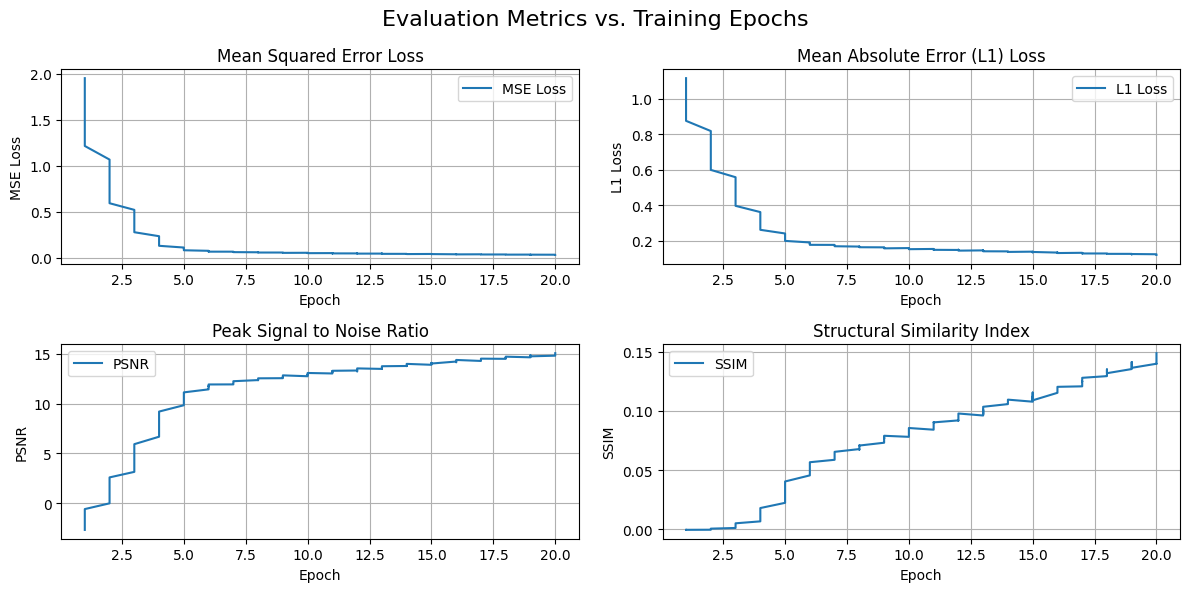

In [ ]:
output_dir = '/content/drive/MyDrive/Output/plots/'
plots_dir = os.path.join(output_dir, 'metric_plots.png')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Plotting the metrics
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
#plt.plot(range(1, num_epochs + 1), mse_losses, label='MSE Loss')
plt.plot(epoch_nums, mse_losses, label='MSE Loss')
plt.title('Mean Squared Error Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
#plt.plot(range(1, num_epochs + 1), l1_losses, label='L1 Loss')
plt.plot(epoch_nums, l1_losses, label='L1 Loss')
plt.title('Mean Absolute Error (L1) Loss')
plt.xlabel('Epoch')
plt.ylabel('L1 Loss')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
#plt.plot(range(1, num_epochs + 1), PSNR_vals, label='PSNR')
plt.plot(epoch_nums, PSNR_vals, label='PSNR')
plt.title('Peak Signal to Noise Ratio')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
#plt.plot(range(1, num_epochs + 1), SSIM_vals, label='SSIM')
plt.plot(epoch_nums, SSIM_vals, label='SSIM')
plt.title('Structural Similarity Index')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.legend()
plt.grid(True)

plt.suptitle('Evaluation Metrics vs. Training Epochs', fontsize=16)
plt.tight_layout()
# Save the plot to a file and display on screen
plt.savefig(plots_dir)
plt.show()